In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, paired_proportions_exact_test, inference_model
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import scipy.io as spio
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, make_dig_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../Preprocessed_EEG/'

labels = list(scipy.io.loadmat(DATA_PATH + 'label.mat')['label'][0])
labels

[1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

In [6]:
files = list(filter(lambda x: x[0].isnumeric() and x[-4:] == '.mat', os.listdir(DATA_PATH)))
len(files)

45

In [7]:
channel_order = pd.read_excel("../China_information.xlsx", sheet_name='Channel_name_and_order')
my_channels = channel_order['Channel Name']
ch_series = pd.DataFrame({'ch_names' :make_standard_montage('standard_1020').ch_names}).ch_names

montage_dict = dict()
base_dict = make_standard_montage('standard_1020', head_size=0.08).get_positions()['ch_pos']
for ch_name in ch_series[ch_series.isin(my_channels)].values:
    montage_dict[ch_name] = base_dict[ch_name]
montage_dict['CB1'] = base_dict['O1']
montage_dict['CB2'] = base_dict['O2']

seed_montage = make_dig_montage(ch_pos=montage_dict)

In [8]:
def calc_shannon_entropy(data_set):
    """
        Input : 1 * N vector
        Output: Float with the wavelet entropy of the input vector,
                rounded to 3 decimal places.
    """
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    return round(shannon_entropy, 3)

In [9]:
from scipy.stats import differential_entropy

def get_bands(data, fs=200):
    # data = data[1]
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    res = []
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        res.append(differential_entropy(fft_vals[freq_ix]))

    return res

In [10]:
def get_bands_freq(data, lenght=266, fs=200):
    data = data[1]
    res = []
    for i in range(0, len(data), fs):
        if len(data[i:i+fs]) == fs:
            res.extend(get_bands(data[i:i+fs], fs))
        
    res += [0] * (5 * lenght - len(res))
    return np.array(res)

In [ ]:
max_len = 0
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        max_len = max(data_df.shape[1], max_len)

max_len

In [ ]:
from multiprocessing import cpu_count, Pool

features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        #sample = np.stack([get_bands(channel[1]) for channel in data_df.iterrows()])
        with Pool(cpu_count()) as p:
            sample = np.stack(p.map(get_bands, data_df.iterrows()))
            p.close()
            p.join()
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

In [11]:
from multiprocessing import cpu_count, Pool

features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        with Pool(cpu_count()) as p:
            sample = np.stack(p.map(get_bands_freq, data_df.iterrows()))
            p.close()
            p.join()
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

100%|███████████████████████████████████████████| 45/45 [13:56<00:00, 18.59s/it]


In [113]:
frac = round(features_tensor.size(0) * 0.1)

train_A_dataset = CNNMatrixDataset(tensors=(features_tensor[:-frac], targets[:-frac]), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(features_tensor[-frac:], targets[-frac:]), with_target=True, transform=None)

batch_size = 128 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [114]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_neighbors_graph

In [209]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 10000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_CNN = BaseCNN(5, 62, time_kernel=3, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=1000)

/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9966	 Min Acc: 0.4931	 Acc: 0.5352	 Max Acc: 0.5773	
val	 Loss: 1.0040	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9531	 Min Acc: 0.5286	 Acc: 0.5704	 Max Acc: 0.6121	
val	 Loss: 0.9856	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9259	 Min Acc: 0.5927	 Acc: 0.6333	 Max Acc: 0.6740	
val	 Loss: 0.9750	 Min Acc: 0.4642	 Acc: 0.5481	 Max Acc: 0.6321	
Epoch 3999/9999
---------------------------------------------------------------------------

In [210]:
count_parameters(model_CNN)

87

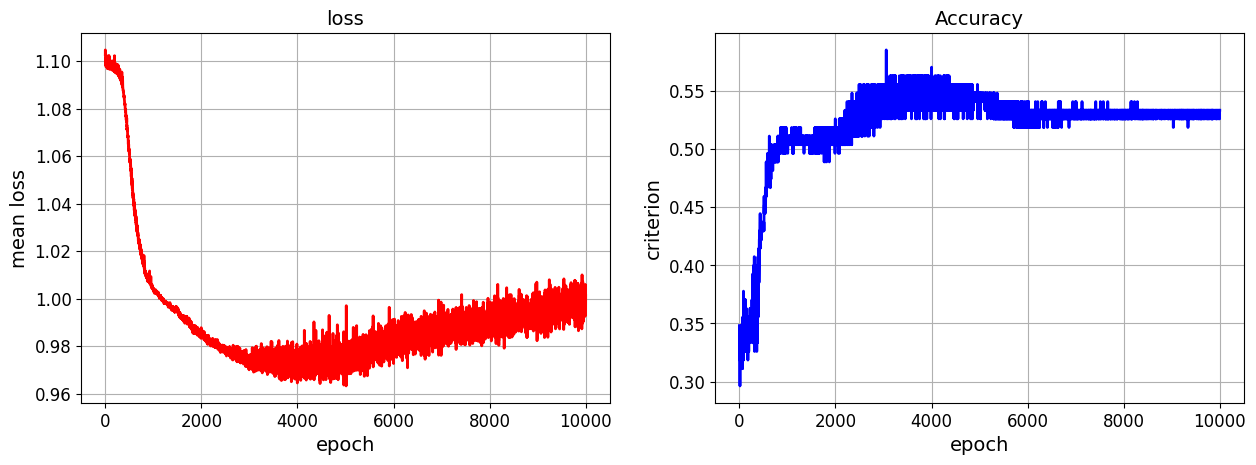

In [211]:
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [213]:
max(acc_cnn['Accuracy'])

0.5851851851851853

In [214]:
t = np.argmax(acc_cnn['Accuracy'])
acc_cnn['Min Accuracy'][t], acc_cnn['Max Accuracy'][t]

(0.5020748569665603, 0.66829551340381)

In [215]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 10000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(5, 62, A, time_kernel=3, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=1000)

cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9958	 Min Acc: 0.4782	 Acc: 0.5204	 Max Acc: 0.5625	
val	 Loss: 0.9741	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9718	 Min Acc: 0.5230	 Acc: 0.5648	 Max Acc: 0.6066	
val	 Loss: 0.9662	 Min Acc: 0.4342	 Acc: 0.5185	 Max Acc: 0.6028	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9559	 Min Acc: 0.5606	 Acc: 0.6019	 Max Acc: 0.6431	
val	 Loss: 0.9710	 Min Acc: 0.4417	 Acc: 0.5259	 Max Acc: 0.6102	
Epoch 3999/9999
---------------------------------------------------------------------------

In [216]:
count_parameters(model_GNN)

241

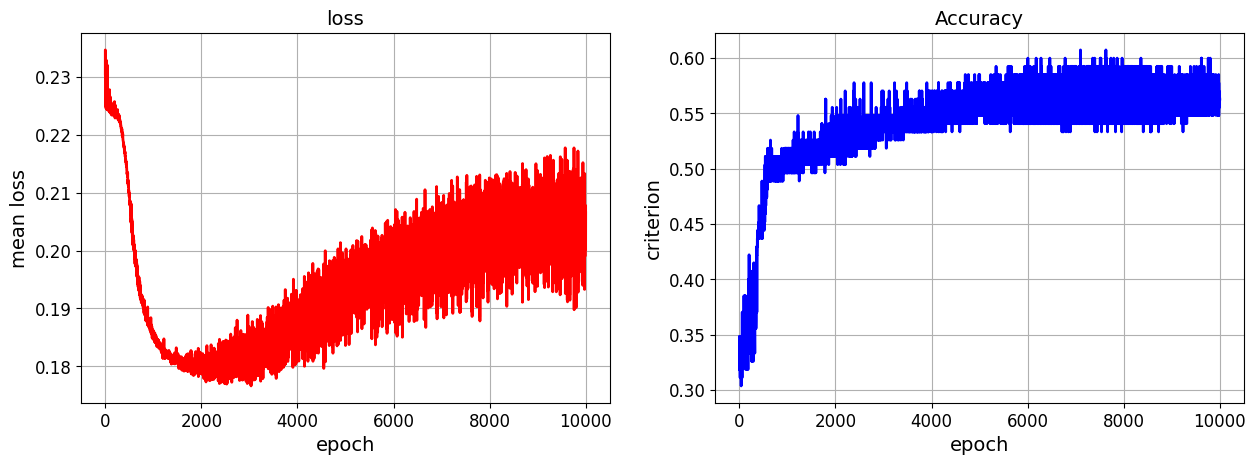

In [217]:
show_progress(loss, acc, 'loss', 'Accuracy')

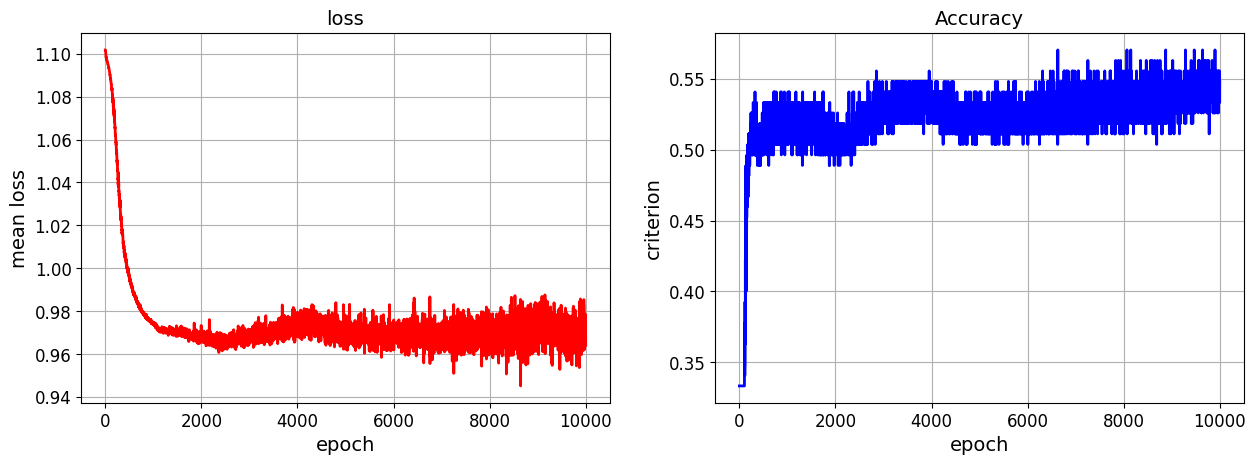

In [218]:
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [219]:
max(acc_gnn['Accuracy'])

0.5703703703703704

In [220]:
t = np.argmax(acc_gnn['Accuracy'])
acc_gnn['Min Accuracy'][t], acc_gnn['Max Accuracy'][t]

(0.4868664630211451, 0.6538742777195957)

In [96]:
for name, param in model_CNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

linear_channel.weight 62
linear_channel.bias 1
conv.weight 3
conv.bias 1
bn1.weight 1
bn1.bias 1
linear_output.weight 15
linear_output.bias 3


In [97]:
for name, param in model_GNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

gc.h.weight 25
gc.h.bias 5
linear_channel.weight 62
linear_channel.bias 1
conv.weight 3
conv.bias 1
bn1.weight 62
bn1.bias 62
bn2.weight 1
bn2.bias 1
linear_output.weight 15
linear_output.bias 3


/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


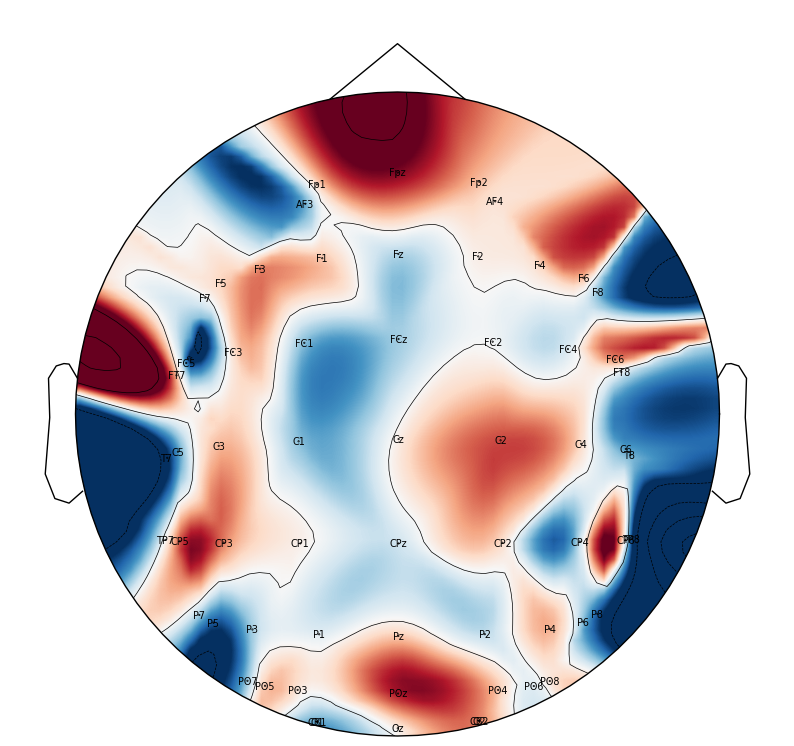

In [145]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

cuda:0


/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.7717	 Min Acc: 0.8747	 Acc: 0.9000	 Max Acc: 0.9253	
val	 Loss: 0.8597	 Min Acc: 0.6749	 Acc: 0.7481	 Max Acc: 0.8214	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6245	 Min Acc: 0.9750	 Acc: 0.9852	 Max Acc: 0.9954	
val	 Loss: 0.7543	 Min Acc: 0.7409	 Acc: 0.8074	 Max Acc: 0.8739	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5847	 Min Acc: 0.9854	 Acc: 0.9926	 Max Acc: 0.9998	
val	 Loss: 0.7292	 Min Acc: 0.7662	 Acc: 0.8296	 Max Acc: 0.8930	
Epoch 399/499
------------------------------------------------------------------------------------------

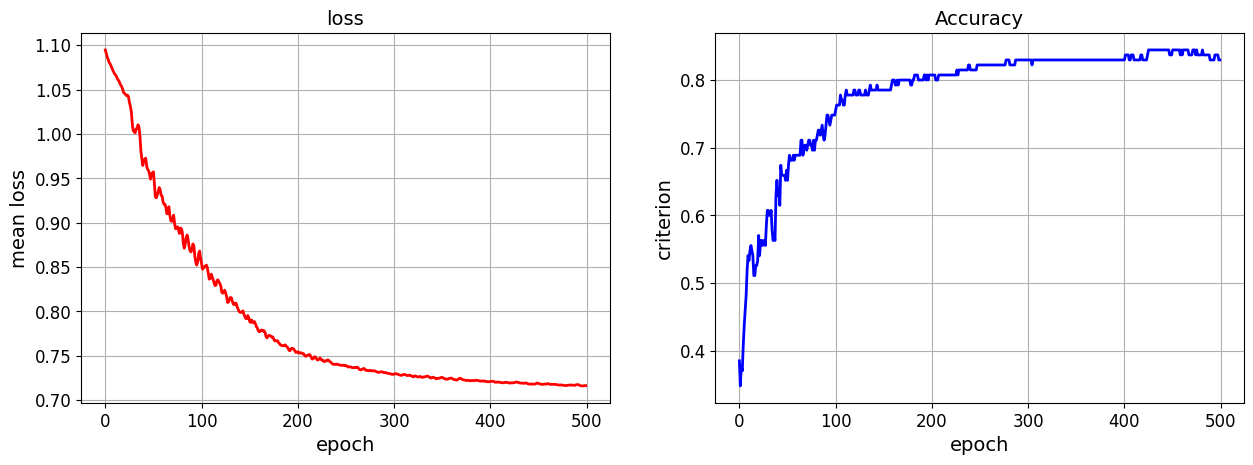

In [16]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = BaseCNN(1330, 62, time_kernel=5, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [17]:
count_parameters(model_CNN)

4064

In [18]:
max(acc_cnn['Accuracy'])

0.8444444444444444

In [19]:
acc_cnn['Min Accuracy'][381], acc_cnn['Max Accuracy'][381]

(0.7662104868297802, 0.893048772429479)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


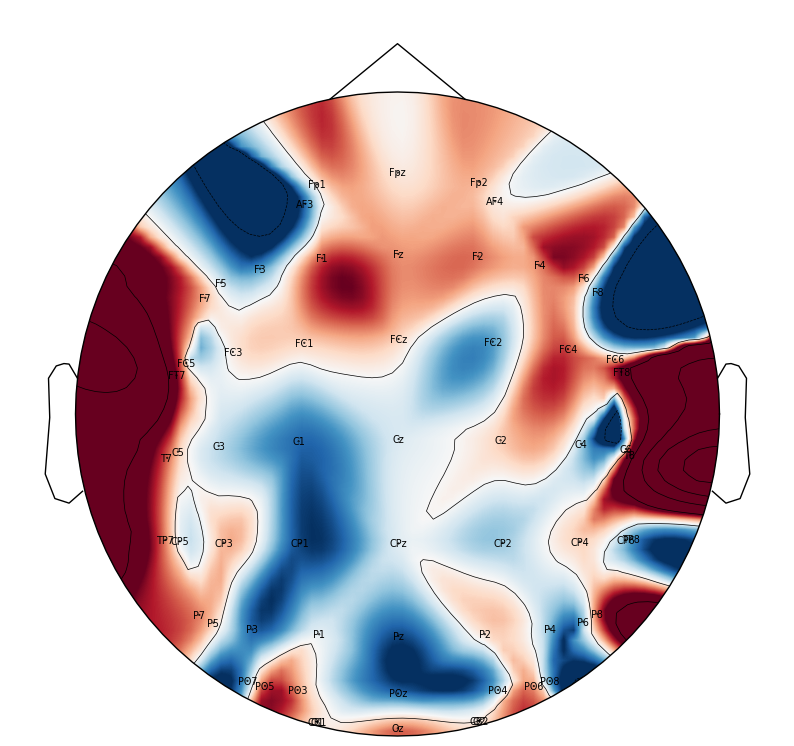

In [20]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

### Experiments

cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6338	 Min Acc: 0.9144	 Acc: 0.9341	 Max Acc: 0.9538	
val	 Loss: 0.6645	 Min Acc: 0.8644	 Acc: 0.9265	 Max Acc: 0.9885	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5536	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6047	 Min Acc: 0.9071	 Acc: 0.9559	 Max Acc: 1.0000	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5521	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6014	 Min Acc: 0.9071	 Acc: 0.9559	 Max Acc: 1.0000	
Epoch 399/499
-----------------------------------------------------------------------------------

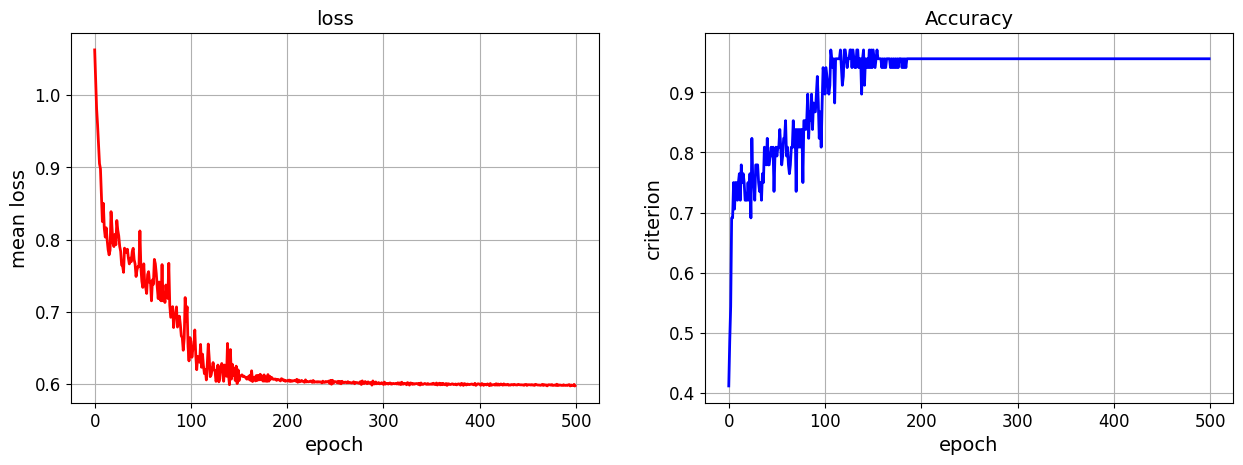

In [115]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [116]:
delaunay_gnn = inference_model(model_GNN, data_loaders_CNN, device=my_device, model_type='CNN')

In [117]:
count_parameters(model_GNN)

1774418

In [118]:
max(acc_gnn['Accuracy'])

0.9705882352941176

In [119]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.9070731149354855, 1.0)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


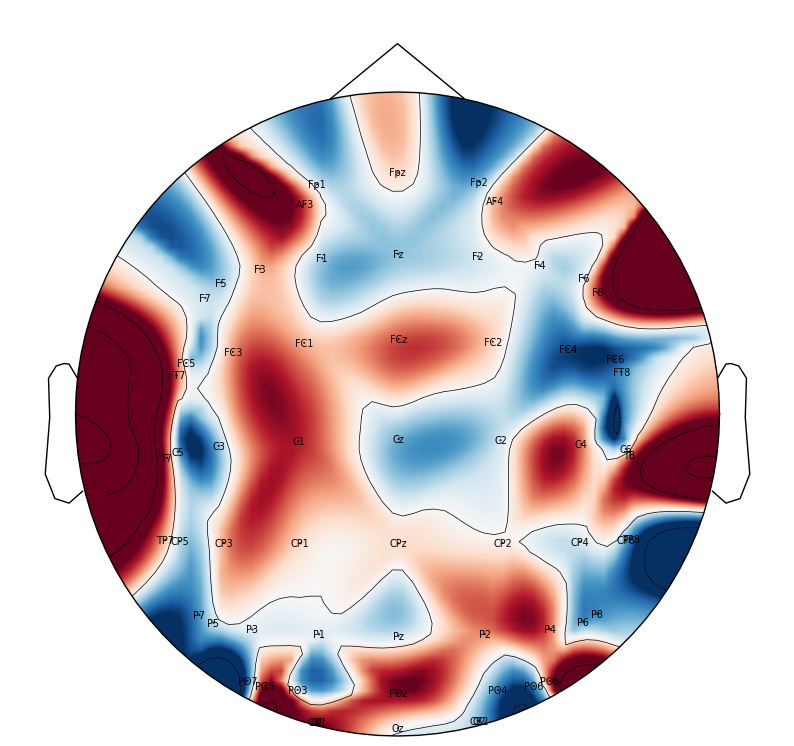

In [120]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [121]:
for name, param in model_CNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

linear_channel.weight 62
linear_channel.bias 1
queries.weight 1768900
queries.bias 1330
keys.weight 1768900
keys.bias 1330
values.weight 1768900
values.bias 1330
attn.in_proj_weight 3
attn.in_proj_bias 3
attn.out_proj.weight 1
attn.out_proj.bias 1
linear_output.weight 3990
linear_output.bias 3


In [122]:
for name, param in model_GNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

gc.h.weight 1768900
gc.h.bias 1330
linear_channel.weight 62
linear_channel.bias 1
conv.weight 5
conv.bias 1
bn1.weight 62
bn1.bias 62
bn2.weight 1
bn2.bias 1
linear_output.weight 3990
linear_output.bias 3


cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5935	 Min Acc: 0.9800	 Acc: 0.9885	 Max Acc: 0.9970	
val	 Loss: 0.7310	 Min Acc: 0.6980	 Acc: 0.7941	 Max Acc: 0.8902	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5533	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6153	 Min Acc: 0.9071	 Acc: 0.9559	 Max Acc: 1.0000	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5521	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6107	 Min Acc: 0.8853	 Acc: 0.9412	 Max Acc: 0.9971	
Epoch 399/499
-----------------------------------------------------------------------------------

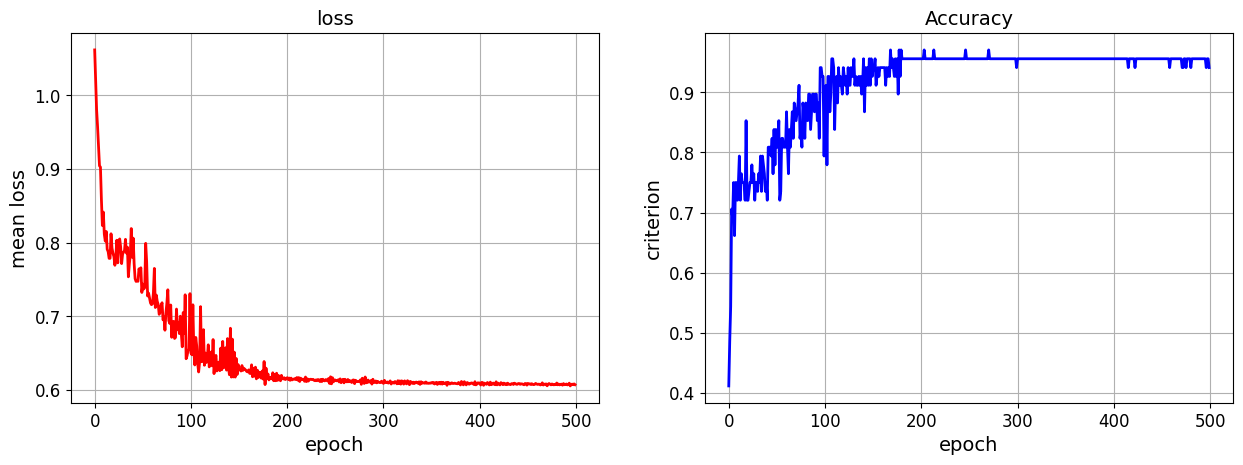

In [123]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_neighbors_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [124]:
knn_gnn = inference_model(model_GNN, data_loaders_CNN, device=my_device, model_type='CNN')

In [125]:
count_parameters(model_GNN)

1774418

In [126]:
max(acc_gnn['Accuracy'])

0.9705882352941176

In [127]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.9070731149354855, 1.0)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


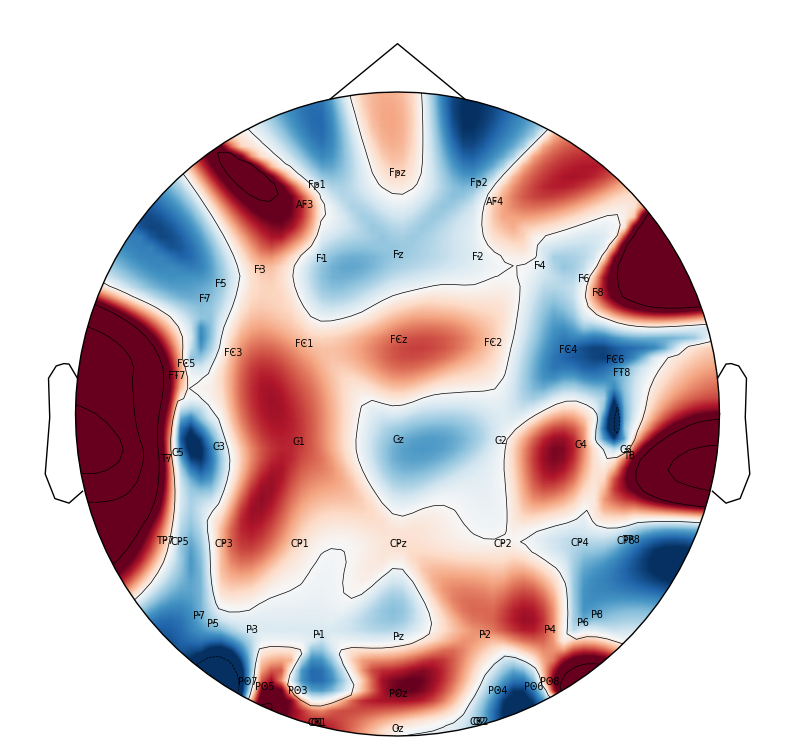

In [128]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

cuda:0


/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.8030	 Min Acc: 0.7014	 Acc: 0.7364	 Max Acc: 0.7715	
val	 Loss: 0.7851	 Min Acc: 0.6639	 Acc: 0.7647	 Max Acc: 0.8655	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.7093	 Min Acc: 0.8146	 Acc: 0.8435	 Max Acc: 0.8724	
val	 Loss: 0.7241	 Min Acc: 0.7329	 Acc: 0.8235	 Max Acc: 0.9141	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6857	 Min Acc: 0.8324	 Acc: 0.8600	 Max Acc: 0.8876	
val	 Loss: 0.7112	 Min Acc: 0.7154	 Acc: 0.8088	 Max Acc: 0.9023	
Epoch 399/499
------------------------------------------------------------------------------------------

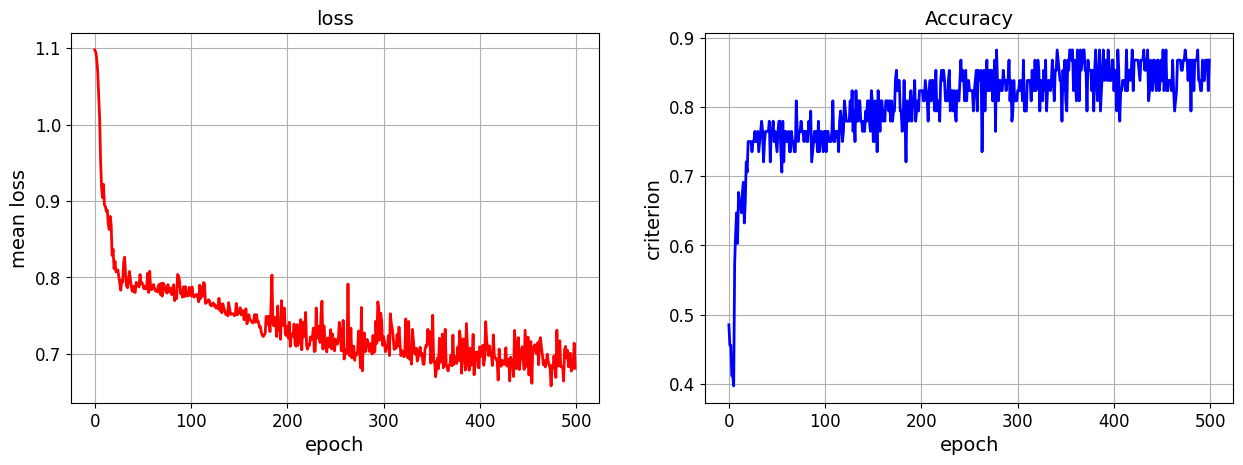

In [129]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = BaseCNNAttn(1330, 62, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [130]:
att_gnn = inference_model(model_GNN, data_loaders_CNN, device=my_device, model_type='CNN')

In [131]:
count_parameters(model_CNN)

5314754

In [132]:
max(acc_cnn['Accuracy'])

0.8823529411764706

In [133]:
acc_cnn['Min Accuracy'][381], acc_cnn['Max Accuracy'][381]

(0.8057747082427433, 0.9589311741101978)

cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5655	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6385	 Min Acc: 0.8443	 Acc: 0.9118	 Max Acc: 0.9792	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5527	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6276	 Min Acc: 0.8644	 Acc: 0.9265	 Max Acc: 0.9885	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5519	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6173	 Min Acc: 0.8853	 Acc: 0.9412	 Max Acc: 0.9971	
Epoch 399/499
-----------------------------------------------------------------------------------

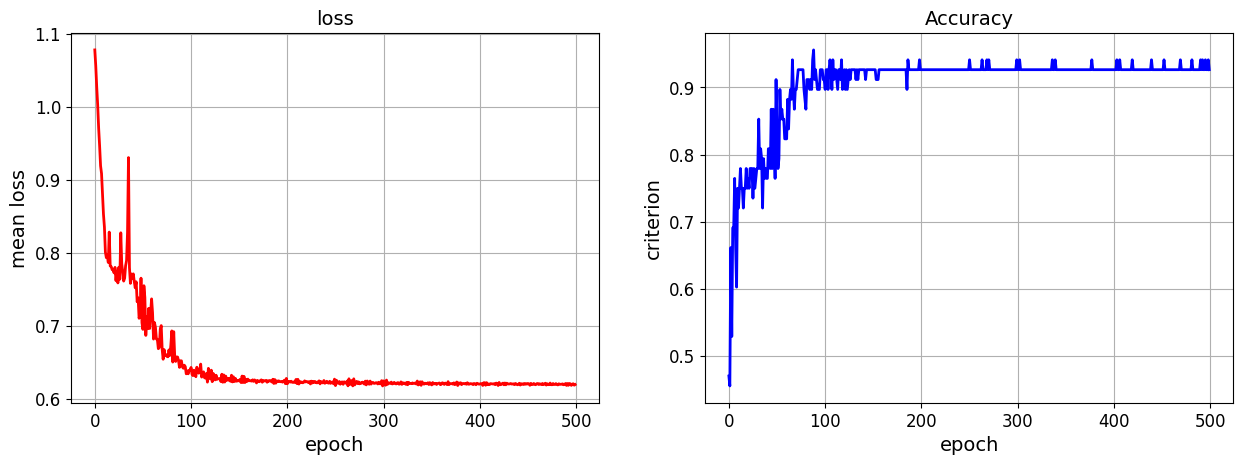

In [134]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

n_channels = 62
B = torch.bernoulli(torch.zeros(n_channels, n_channels) + 0.5)
i, j = torch.triu_indices(n_channels, n_channels)
B[i, j] = B.T[i, j]
k = torch.arange(n_channels)
B[k, k] = 0

model_GNN = BaseGNN(1330, 62, B.to(my_device), time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [135]:
rand_gnn = inference_model(model_GNN, data_loaders_CNN, device=my_device, model_type='CNN')

In [136]:
count_parameters(model_GNN)

1774418

In [137]:
max(acc_gnn['Accuracy'])

0.9558823529411764

In [138]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.8644351293870738, 0.9885060470835145)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


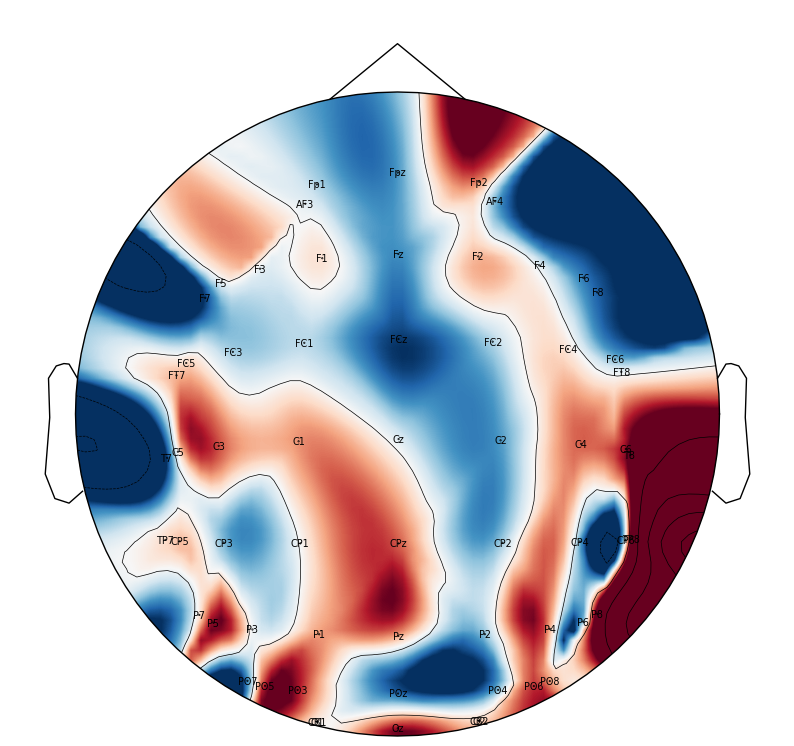

In [139]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5581	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.7062	 Min Acc: 0.7507	 Acc: 0.8382	 Max Acc: 0.9258	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5526	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.7009	 Min Acc: 0.7507	 Acc: 0.8382	 Max Acc: 0.9258	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5519	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.7019	 Min Acc: 0.7507	 Acc: 0.8382	 Max Acc: 0.9258	
Epoch 399/499
-----------------------------------------------------------------------------------

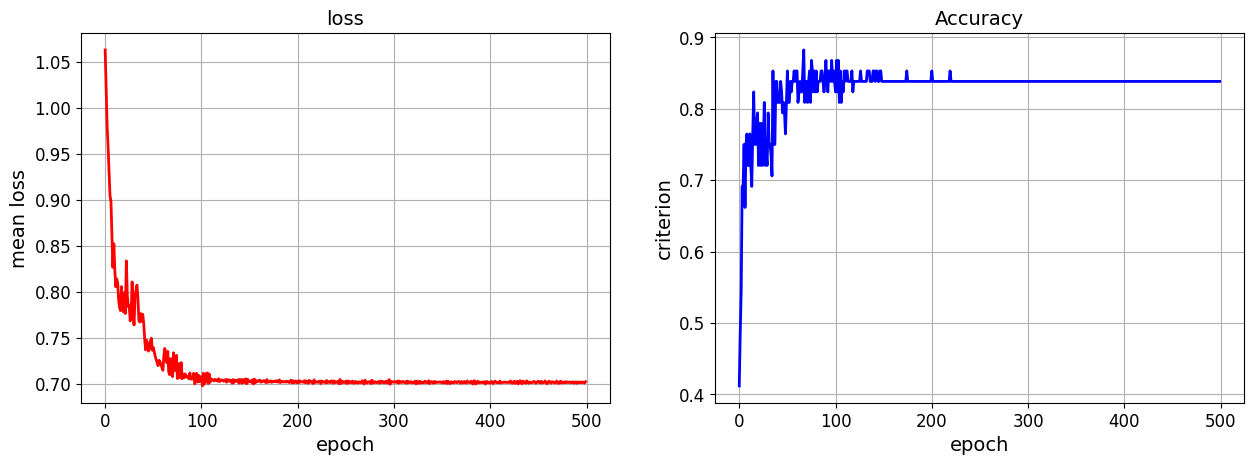

In [140]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

n_channels = 62
B = torch.eye(n_channels)

model_GNN = BaseGNN(1330, 62, B.to(my_device), time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [141]:
count_parameters(model_GNN)

1774418

In [142]:
max(acc_gnn['Accuracy'])

0.8823529411764706

In [143]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.750713040387392, 0.9257575478479022)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


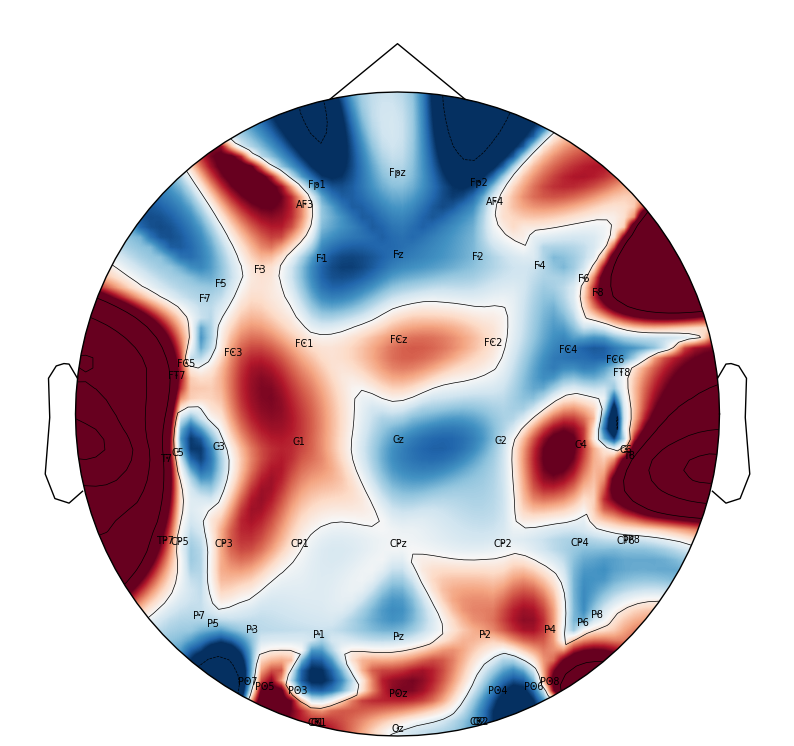

In [144]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [145]:
eye_gnn = inference_model(model_GNN, data_loaders_CNN, device=my_device, model_type='CNN')

In [146]:
paired_proportions_exact_test(delaunay_gnn, eye_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(21), tensor(1)], [tensor(4), tensor(42)]]


0.375

In [147]:
paired_proportions_exact_test(delaunay_gnn, knn_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(21), tensor(1)], [tensor(0), tensor(46)]]


1.0

In [148]:
paired_proportions_exact_test(knn_gnn, eye_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(21), tensor(0)], [tensor(4), tensor(43)]]


0.125

In [149]:
paired_proportions_exact_test(delaunay_gnn, rand_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(8), tensor(14)], [tensor(17), tensor(29)]]


0.720100131817162

In [150]:
paired_proportions_exact_test(att_gnn, eye_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(6), tensor(12)], [tensor(19), tensor(31)]]


0.28104151505976915

In [151]:
res = []

for first in [eye_gnn, rand_gnn, att_gnn, knn_gnn, delaunay_gnn]:
    row = []
    for second in [eye_gnn, rand_gnn, att_gnn, knn_gnn, delaunay_gnn]:
        row.append(paired_proportions_exact_test(first, second, torch.max(targets, dim=1)[1][-frac:]))
    res.append(row)

[[tensor(25), tensor(0)], [tensor(0), tensor(43)]]
[[tensor(8), tensor(17)], [tensor(17), tensor(26)]]
[[tensor(6), tensor(19)], [tensor(12), tensor(31)]]
[[tensor(21), tensor(4)], [tensor(0), tensor(43)]]
[[tensor(21), tensor(4)], [tensor(1), tensor(42)]]
[[tensor(8), tensor(17)], [tensor(17), tensor(26)]]
[[tensor(25), tensor(0)], [tensor(0), tensor(43)]]
[[tensor(9), tensor(16)], [tensor(9), tensor(34)]]
[[tensor(8), tensor(17)], [tensor(13), tensor(30)]]
[[tensor(8), tensor(17)], [tensor(14), tensor(29)]]
[[tensor(6), tensor(12)], [tensor(19), tensor(31)]]
[[tensor(9), tensor(9)], [tensor(16), tensor(34)]]
[[tensor(18), tensor(0)], [tensor(0), tensor(50)]]
[[tensor(6), tensor(12)], [tensor(15), tensor(35)]]
[[tensor(6), tensor(12)], [tensor(16), tensor(34)]]
[[tensor(21), tensor(0)], [tensor(4), tensor(43)]]
[[tensor(8), tensor(13)], [tensor(17), tensor(30)]]
[[tensor(6), tensor(15)], [tensor(12), tensor(35)]]
[[tensor(21), tensor(0)], [tensor(0), tensor(47)]]
[[tensor(21), tensor(

<Axes: >

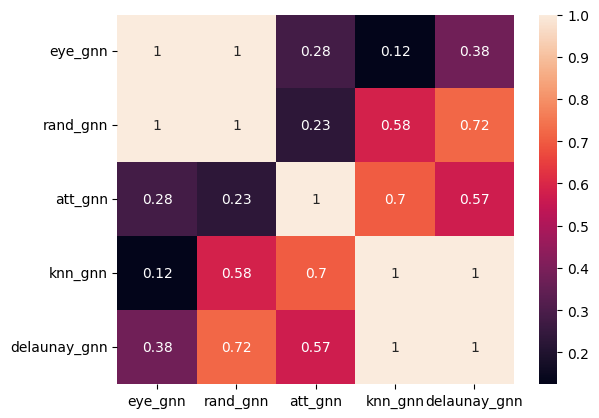

In [152]:
import seaborn as sns

df = pd.DataFrame(res, columns=['eye_gnn', 'rand_gnn', 'att_gnn', 'knn_gnn', 'delaunay_gnn'], index=['eye_gnn', 'rand_gnn', 'att_gnn', 'knn_gnn', 'delaunay_gnn'])

sns.heatmap(df, annot=True)

In [153]:
paired_proportions_exact_test(eye_gnn, eye_gnn, torch.max(targets, dim=1)[1][-frac:])

[[tensor(25), tensor(0)], [tensor(0), tensor(43)]]


1.0

In [154]:
import scipy

scipy.stats.f.cdf(4, 1, 1)

0.7048327646991334